In [1]:
# mike babb
# 2024 06 28
# what streets start and stop?

In [2]:
# standard
import os

In [3]:
# external
from itertools import combinations, product
import geopandas as gpd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import LineString, Point
from shapely import line_merge

In [4]:
# custom
from geodataio.geo_operations import points2distance, calculate_initial_compass_bearing
from utils import *

# OUTPUT

In [5]:
output_file_path = 'H:/project/seattle_streets/data/' 

In [6]:
output_file_name = 'street_analysis.xlsx'

In [7]:
ofpn = os.path.join(output_file_path, output_file_name)

In [8]:
e_writer = pd.ExcelWriter(path = ofpn)

# load the street network

In [9]:
# file path
input_file_path = 'H:/project/seattle_streets/data/' 

In [10]:
file_name = 'missing_segments.gpkg'

In [11]:
fpn = os.path.join(input_file_path, file_name)

In [12]:
gdf = gpd.read_file(filename = fpn)

In [13]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_stname_concat', 'ord_street_type',
       'snd_group', 'street_status', 'sn_id', 'en_id', 'dist', 'dist_miles',
       'geometry'],
      dtype='object')

In [14]:
gdf['n_segments'] = int(1)

In [15]:
missing_dict = {0:'complete_street',
                1:'disconnected_street',
                2:'missing_street'}

In [16]:
gdf['street_status_desc'] = gdf['street_status'].map(missing_dict)

# WHAT STREET NAME HAS THE MOST STREET TYPES?

In [17]:
col_names = ['ord_street_name', 'ord_street_type', 'n_segments']

In [18]:
gdf_agg = gdf[col_names].drop_duplicates()

In [19]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['ord_street_type'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [20]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [21]:
gdf_pv.head()

,ord_street_name,AVE,BLVD,BR,CIR,CT,DR,LN,LOOP,MALL,PKWY,PL,PZ,RD,ST,TER,VIEW,WAY,All
0,100TH,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
1,101ST,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
2,102ND,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2
3,103RD,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
4,104TH,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,4


In [22]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 's_type_count', index = False)

# WHAT STREET NAME HAS THE MOST STREET CONNECTIONS?

In [23]:
col_names = ['ord_street_name', 'ord_stname_concat', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates()

In [24]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [25]:
gdf_pv.head()

ord_street_name      n_segments                      \
street_status_desc                 complete_street disconnected_street   
0                            100TH               3                   4   
1                            101ST               3                   2   
2                            102ND               2                   3   
3                            103RD               2                   5   
4                            104TH               4                   4   

                                       
street_status_desc missing_street All  
0                               4  11  
1                               2   7  
2                               3   8  
3                               5  12  
4                               4  12

In [26]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [27]:
gdf_pv.columns

Index(['ord_street_name', 'complete_street', 'disconnected_street',
       'missing_street', 'All'],
      dtype='object')

In [28]:
gdf_pv.head()

,ord_street_name,complete_street,disconnected_street,missing_street,All
0,100TH,3,4,4,11
1,101ST,3,2,2,7
2,102ND,2,3,3,8
3,103RD,2,5,5,12
4,104TH,4,4,4,12


In [29]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_by_name', index = False)

# COUNT OF DISCONNECTED STREETS

In [30]:
col_names = ['ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names]

In [31]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = ['ord_stname_concat', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [32]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [33]:
gdf_pv.head()

,ord_stname_concat,ord_street_type,complete_street,disconnected_street,missing_street,All
0,10TH AVE,AVE,0,11,3,14
1,10TH AVE E,AVE,0,21,3,24
2,10TH AVE NE,AVE,7,0,0,7
3,10TH AVE NW,AVE,0,14,4,18
4,10TH AVE S,AVE,0,32,7,39


In [34]:
gdf_pv.shape

(2498, 6)

In [35]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_full_name', index = False)

In [36]:
# remove the all row
w_gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_concat'] != 'All', :]

In [37]:
w_gdf_pv.shape

(2497, 6)

In [38]:
# number of streets with at least one missing segment
split_streets = w_gdf_pv.loc[w_gdf_pv['disconnected_street'] > 0, :].shape[0]
split_streets

1140

In [39]:
# number of streets with no missing segments
complete_streets = w_gdf_pv.loc[w_gdf_pv['complete_street'] > 0, :].shape[0]
complete_streets

1357

In [40]:
split_streets / w_gdf_pv.shape[0]

0.4565478574289147

In [41]:
complete_streets / w_gdf_pv.shape[0]

0.5434521425710853

In [43]:
# 46 percent of streets are multi-segments.
# 54 percent of streets are single segment.

# SUM OF ROAD MILES BY DISCONNECTED STREET

In [44]:
col_names = ['ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'dist_miles']
gdf_agg = gdf[col_names]

In [45]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['dist_miles'], index = ['ord_stname_concat', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [46]:
gdf_pv.columns = [''.join(cn).replace('dist_miles', '') for cn in gdf_pv.columns]

In [47]:
gdf_pv.head()

,ord_stname_concat,ord_street_type,complete_street,disconnected_street,missing_street,All
0,10TH AVE,AVE,0.00000,0.613528,0.328426,0.941954
1,10TH AVE E,AVE,0.00000,1.942426,0.051903,1.994328
2,10TH AVE NE,AVE,0.48567,0.000000,0.000000,0.485670
3,10TH AVE NW,AVE,0.00000,1.701021,1.753063,3.454084
4,10TH AVE S,AVE,0.00000,2.025667,4.517775,6.543441


In [54]:
# WHICH STREETS FEATURE LONGER DISCONNECTED PORTIONS?
gdf_pv['longer_missing'] = int(0) # street is complete
gdf_pv.loc[(gdf_pv['complete_street'] == 0) & (gdf_pv['missing_street'] <= gdf_pv['disconnected_street']), 'longer_missing'] = int(1)
gdf_pv.loc[(gdf_pv['complete_street'] == 0) & (gdf_pv['missing_street'] > gdf_pv['disconnected_street']), 'longer_missing'] = int(2)

In [55]:
gdf_pv['longer_missing'].value_counts()

longer_missing
0    1358
1     840
2     300
Name: count, dtype: int64

In [56]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'distance_full_name', index = False)

In [57]:
# remove the all row
w_gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_concat'] != 'All', :]

In [58]:
w_gdf_pv.shape

(2497, 7)

In [62]:
# number of streets with at least one missing segment
split_streets = w_gdf_pv['disconnected_street'].sum()
split_streets

1511.0745079236742

In [63]:
# number of streets with no missing segments
complete_streets = w_gdf_pv['complete_street'].sum()
complete_streets

420.9508936253788

In [65]:
split_streets / (split_streets + complete_streets)

0.7821193793374196

In [67]:
complete_streets / (split_streets + complete_streets)

0.2178806206625804

In [68]:
# 78 percent of streets are multi-segments streets
# 22 percent of road miles are single segment streets

In [69]:
e_writer.close()

# LONGEST MISSING STREETS

In [70]:
wms_gdf = gdf.loc[gdf['street_status'] == 2, :].copy()

In [71]:
wms_gdf['dist_rank'] = wms_gdf['dist'].rank(method = 'dense', ascending = False)

In [72]:
wms_gdf.loc[wms_gdf['dist_rank'] <= 10, 'ord_stname_concat'].tolist()

['S 112TH ST',
 'S 106TH ST',
 '20TH AVE S',
 '11TH AVE S',
 '33RD AVE SW',
 'S 105TH ST',
 '9TH AVE S',
 'S 116TH ST',
 '7TH PL S',
 'S 108TH ST']

In [73]:
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [74]:
wms_gdf['dist_miles_log'].describe()

count    3643.000000
mean       -1.024413
std         0.577650
min        -3.128428
25%        -1.486670
50%        -1.075904
75%        -0.601155
max         0.696677
Name: dist_miles_log, dtype: float64

# LET'S MAKE A GRAPHIC SHOWING THE DISTRIBUTION OF ADDED STREETS

In [80]:
ds_df = wms_gdf['dist_miles'].describe().to_frame().reset_index(names = ['stat'])

In [81]:
ds_df = ds_df.loc[-ds_df['stat'].isin(['count', 'std']), :]

In [82]:
# add the 95-percentile
temp_stat_records = [
    ['10%', np.quantile(a = wms_gdf['dist_miles'], q = 0.10)],
    ['95%', np.quantile(a = wms_gdf['dist_miles'], q = 0.95)],
    ['99%', np.quantile(a = wms_gdf['dist_miles'], q = 0.99)]
]
temp_stat_df = pd.DataFrame(data = temp_stat_records, columns = ds_df.columns)
temp_stat_df.head()

,stat,dist_miles
0,10%,0.018747
1,95%,0.962718
2,99%,1.797078


In [83]:
ds_df = pd.concat(objs = [ds_df, temp_stat_df], axis = 0)

In [84]:
ds_df = ds_df.sort_values(by = ['dist_miles'])

In [85]:
ds_df['dist_miles_log'] = ds_df['dist_miles'].map(lambda x: np.log10(x))

In [86]:
ds_df['color_list'] = 'red'

In [87]:
ds_df.loc[ds_df['stat'].isin(['min','mean','max']), 'color_list'] = 'black'

In [88]:
ds_df['dist_feet'] = ds_df['dist_miles'] * 5280

In [161]:
ds_df['text_ha'] = ['left', 'right',  'center', 'right', 'right', 'left', 'center', 'center', 'right']

In [162]:
ds_df['text'] = ['4ft (min)', '99 ft (10%)', '172 ft (25%)', '443 ft (med.)', '0.23 mi (avg.)', '0.25 mi (75%)', '0.96 mi (95%)','1.8 mi (99%)', '5 mi (max)']

In [163]:
ds_df['text_jitter'] = [0, .001, 0, .05, 0, 0, -.05, 0, 0]

In [164]:
ds_df['text_x_pos'] = ds_df['dist_miles_log'] + ds_df['text_jitter']

In [165]:
ds_df.head(n=10)

,stat,dist_miles,dist_miles_log,color_list,dist_feet,text_ha,text,text_jitter,text_x_pos
3,min,0.000744,-3.128428,black,3.928314,left,4ft (min),0.000,-3.128428
0,10%,0.018747,-1.727074,red,98.982774,right,99 ft (10%),0.001,-1.726074
4,25%,0.032608,-1.486670,red,172.172750,center,172 ft (25%),0.000,-1.486670
5,50%,0.083964,-1.075904,red,443.332350,right,443 ft (med.),0.050,-1.025904
1,mean,0.228895,-0.640363,black,1208.567839,right,0.23 mi (avg.),0.000,-0.640363
6,75%,0.250521,-0.601155,red,1322.752385,left,0.25 mi (75%),0.000,-0.601155
1,95%,0.962718,-0.016501,red,5083.153075,center,0.96 mi (95%),-0.050,-0.066501
2,99%,1.797078,0.254567,red,9488.573933,center,1.8 mi (99%),0.000,0.254567
7,max,4.973674,0.696677,black,26261.000182,right,5 mi (max),0.000,0.696677


10
10
..\assets\dist_histogram.png


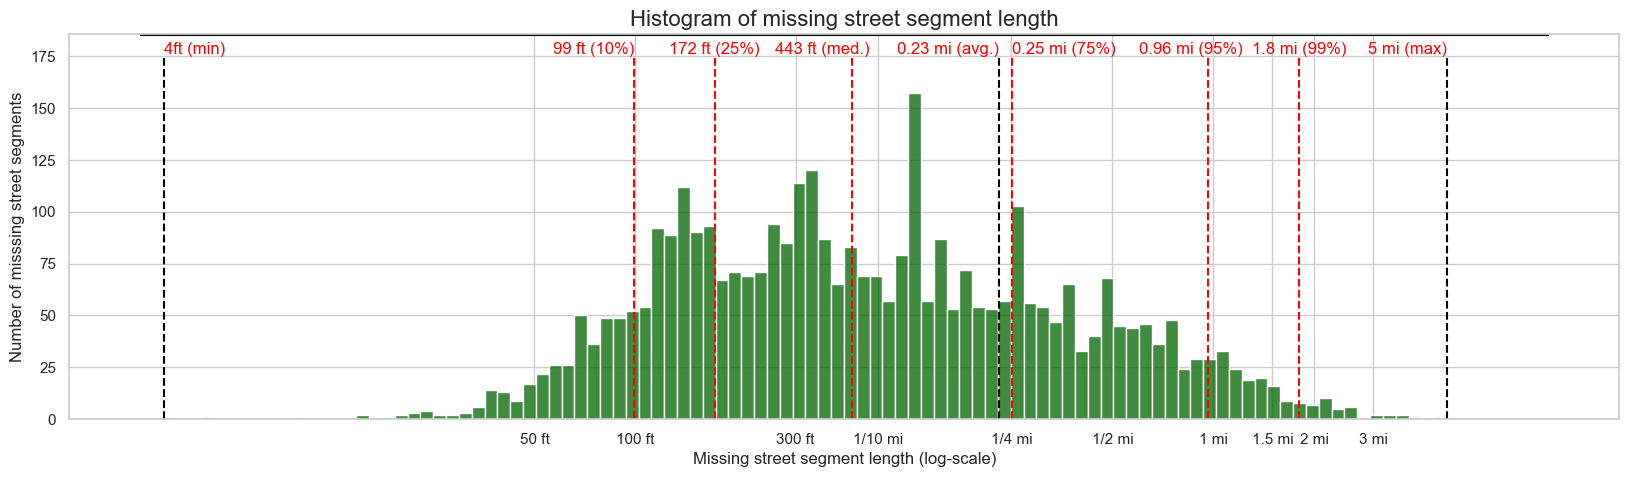

In [182]:
# let's make a graphic showing the distances
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)

my_plot = sns.histplot(data = wms_gdf, x = 'dist_miles_log',
                      color='darkgreen', bins = 100)

y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

plt.title(label = "Histogram of missing street segment length", fontsize = 16)
plt.xlabel(xlabel = 'Missing street segment length (log-scale)')
plt.ylabel(ylabel = "Number of misssing street segments")

x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 1.5, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
print(len(x_ticks))

x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '1.5 mi', '2 mi', '3 mi']
print(len(x_tick_label_text))

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = ds_df['dist_miles_log'], ymin = 0, ymax = 175, color = ds_df['color_list'], linestyles = 'dashed')
my_plot.hlines(y = 185, xmin = -3.2, xmax = 1, colors = 'black')

for ir, row in ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 176, s = row['text'], horizontalalignment = row['text_ha'], color = 'red')


output_file_name = '..\\assets\\dist_histogram.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()